### AI Bootcamp - June 2024 Cohort - Analyzing and Predicting Flight Delays
Documentation and Context: See the project's ReadMe.md file for documentation on the column names and purposes.

### What's in this workbook?
This is a starter Jupyter Notebook for the project team to use when building out various machine learning models. Each team member will create a copy of this notebook for their work. 

## Libraries Imported
* Pandas
* Numpy
* Matplotlib
* sklearn
    * StandardScaler
    * PCA
    * LabelEncoder

In [2]:
# Do imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

### Read In Data to Dataframe

In [3]:
# Create DataFrame
df = pd.read_csv('./data/Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.00000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.00000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.60446,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.00000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.50000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.00000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.50000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.00000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [5]:
len(df['AirportFrom'].unique())

293

In [6]:
df['Time_encoded'] = df['Time'].apply(lambda x: f"{x // 60:02d}:{x % 60:02d}")
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded
0,1,CO,269,SFO,IAH,3,15,205,1,00:15
1,2,US,1558,PHX,CLT,3,15,222,1,00:15
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20
4,5,AS,108,ANC,SEA,3,30,202,0,00:30


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            539383 non-null  int64 
 1   Airline       539383 non-null  object
 2   Flight        539383 non-null  int64 
 3   AirportFrom   539383 non-null  object
 4   AirportTo     539383 non-null  object
 5   DayOfWeek     539383 non-null  int64 
 6   Time          539383 non-null  int64 
 7   Length        539383 non-null  int64 
 8   Delay         539383 non-null  int64 
 9   Time_encoded  539383 non-null  object
dtypes: int64(6), object(4)
memory usage: 41.2+ MB


### Preprocessing : Encoding 'AirportFrom', 'AirportTo', 'Airline' Columns

In [8]:
airport_codes = df['AirportFrom'].unique()
airport_codes

array(['SFO', 'PHX', 'LAX', 'ANC', 'LAS', 'SLC', 'DEN', 'ONT', 'FAI',
       'BQN', 'PSE', 'HNL', 'BIS', 'IYK', 'EWR', 'BOS', 'MKE', 'GFK',
       'OMA', 'GSO', 'LMT', 'SEA', 'MCO', 'TPA', 'DLH', 'MSP', 'FAR',
       'MFE', 'MSY', 'VPS', 'BWI', 'MAF', 'LWS', 'RST', 'ALB', 'DSM',
       'CHS', 'MSN', 'JAX', 'SAT', 'PNS', 'BHM', 'LIT', 'SAV', 'BNA',
       'ICT', 'ECP', 'DHN', 'MGM', 'CAE', 'PWM', 'ACV', 'EKO', 'PHL',
       'ATL', 'PDX', 'RIC', 'BTR', 'HRL', 'MYR', 'TUS', 'SBN', 'CAK',
       'TVC', 'CLE', 'ORD', 'DAY', 'MFR', 'BTV', 'TLH', 'TYS', 'DFW',
       'FLL', 'AUS', 'CHA', 'CMH', 'LRD', 'BRO', 'CRP', 'LAN', 'PVD',
       'FWA', 'JFK', 'LGA', 'OKC', 'PIT', 'PBI', 'ORF', 'DCA', 'AEX',
       'SYR', 'SHV', 'VLD', 'BDL', 'FAT', 'BZN', 'RDM', 'LFT', 'IPL',
       'EAU', 'ERI', 'BUF', 'IAH', 'MCI', 'AGS', 'ABI', 'GRR', 'LBB',
       'CLT', 'LEX', 'MBS', 'MOD', 'AMA', 'SGF', 'AZO', 'ABE', 'SWF',
       'BGM', 'AVP', 'FNT', 'GSP', 'ATW', 'ITH', 'TUL', 'COS', 'ELP',
       'ABQ', 'SMF',

### Make a copy of Dataframe for preprocessing

In [9]:
encoded_df = df.copy()

In [10]:
unique_codes = encoded_df['AirportFrom'].unique()
code_to_id = {code: idx for idx, code in enumerate(unique_codes, start=1)}

# Apply the mapping to create a new column with unique IDs
encoded_df['AirportFroIDs'] = encoded_df['AirportFrom'].map(code_to_id)
encoded_df['AirportToIDs'] = encoded_df['AirportTo'].map(code_to_id)

encoded_df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22
...,...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,23:59,194,229
539379,539380,FL,398,SEA,ATL,5,1439,305,0,23:59,22,55
539380,539381,FL,609,SFO,MKE,5,1439,255,0,23:59,1,17
539381,539382,UA,78,HNL,SFO,5,1439,313,1,23:59,12,1


In [11]:
# Get unique airline codes
unique_airlines = encoded_df['Airline'].unique()

# Create a random mapping for each unique airline code
random.seed(42)  # Set a seed for reproducibility, remove if you want different random results each time
airline_to_id = {airline: random.randint(1000, 9999) for airline in unique_airlines}

# Apply the random mapping to the airline column
encoded_df['airline_id'] = encoded_df['Airline'].map(airline_to_id)

encoded_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,CO,269,SFO,IAH,3,15,205,1,00:15,1,103,2824
1,2,US,1558,PHX,CLT,3,15,222,1,00:15,2,109,1409
2,3,AA,2400,LAX,DFW,3,20,165,1,00:20,3,72,5506
3,4,AA,2466,SFO,DFW,3,20,195,1,00:20,1,72,5506
4,5,AS,108,ANC,SEA,3,30,202,0,00:30,4,22,5012


In [12]:
len(encoded_df["AirportFrom"].unique())

293

In [13]:
len(encoded_df["AirportTo"].unique())

293

In [14]:
# Drop all the categorical columns
encoded_df = encoded_df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
encoded_df.head()

,id,Flight,DayOfWeek,Time,Length,Delay,Time_encoded,AirportFroIDs,AirportToIDs,airline_id
0,1,269,3,15,205,1,00:15,1,103,2824
1,2,1558,3,15,222,1,00:15,2,109,1409
2,3,2400,3,20,165,1,00:20,3,72,5506
3,4,2466,3,20,195,1,00:20,1,72,5506
4,5,108,3,30,202,0,00:30,4,22,5012


In [15]:
# Drop unused columns

encoded_df = encoded_df.copy()
encoded_df.drop(['id', 'Time_encoded'], axis=1, inplace=True)


In [16]:
X = encoded_df.copy()
X.drop('Delay', axis=1, inplace=True)
X.head()

,Flight,DayOfWeek,Time,Length,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,103,2824
1,1558,3,15,222,2,109,1409
2,2400,3,20,165,3,72,5506
3,2466,3,20,195,1,72,5506
4,108,3,30,202,4,22,5012


In [17]:
y = df['Delay']

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Scale the Data
SVM, KNN, K-Means, and PCA need scaling

In [19]:
# Scaling the X data by using StandardScaler()
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.09447296,  1.08199271,  0.01063145, ...,  1.82992654,
        -1.05211002, -0.75328146],
       [ 2.01121043, -1.00719177,  1.00286384, ...,  2.43184152,
        -0.19638348,  2.16454157],
       [-0.8346985 ,  0.55969659, -0.35246809, ..., -1.21132809,
        -0.38654493, -1.26398092],
       ...,
       [ 0.14828415, -1.00719177, -1.26920454, ...,  0.8636946 ,
        -0.83025499,  0.04212289],
       [ 1.46021769, -0.48489565, -0.83779915, ..., -0.37181509,
        -0.76686784, -1.21934498],
       [ 0.77038833, -0.48489565, -0.22664152, ...,  0.89537434,
        -0.19638348,  0.10405023]])

In [20]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.13268931,  0.03740047, -0.99957617, ..., -1.21132809,
        -0.35485136, -1.26398092],
       [-0.45737249, -0.48489565, -1.44895678, ...,  0.3726587 ,
        -0.87779535, -0.11872733],
       [ 0.77232333,  0.55969659,  0.52831791, ...,  0.10338094,
        -0.37069815, -0.85582348],
       ...,
       [ 1.25752589, -1.52948788, -1.59275858, ...,  1.03793315,
        -0.37069815, -1.21934498],
       [ 0.59527036,  1.60428882,  1.08554987, ..., -1.21132809,
         0.94458524, -0.11872733],
       [-0.66054803,  0.55969659, -0.04688927, ..., -0.0708576 ,
         0.07301191, -0.50919125]])

### SVM

In [21]:
# Create the support vector machine classifier model
svc_model = SVC(kernel='linear', max_iter=10000)

In [22]:
svc_model.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=10000)

In [23]:
# Validate the model by checking the model accuracy with model.score
svc_train_score = svc_model.score(X_train_scaled, y_train) 
print(f'The SVC training score is: {svc_train_score}')
svc_test_score = svc_model.score(X_test_scaled, y_test)
print(f'The SVC testing score is: {svc_test_score}') 

The SVC training score is: 0.44740777728613207
The SVC testing score is: 0.44729543330910815


### Random Forest

In [24]:
# Create and train a randomforest model
random_model = RandomForestClassifier(n_estimators=500, max_depth=5)
random_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [25]:
# Check the model's balanced accuracy on the TEST set
y_test_pred = random_model.predict(X_test)
ran_test_bal_score = balanced_accuracy_score(y_test, y_test_pred) 
print(ran_test_bal_score)
# print(balanced_accuracy_score(y_test, y_test_pred))

0.6057454630604511


In [26]:
# Check the model's balanced accuracy on the training set
y_train_pred = random_model.predict(X_train)
ran_train_bal_score = balanced_accuracy_score(y_train, y_train_pred)
print(ran_train_bal_score)
# print(balanced_accuracy_score(y_train, y_train_pred))

0.6058754267153794


### Logistic Regression

In [27]:
# Create a LogisticRegression function
logistic_regression_model = LogisticRegression(max_iter=1000)

In [28]:
# Fit the model for Logistic Regression
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [29]:
# Score the model
print(f'The training data score: {logistic_regression_model.score(X_train, y_train)}')
print(f'The testing data score: {logistic_regression_model.score(X_test, y_test)}')
      

The training data score: 0.5694584178950257
The testing data score: 0.5707622028091304


In [30]:
# Generate predictions from the model we just fit
log_predictions = logistic_regression_model.predict(X_train)

# Convert those predictions (and actual values) to a DataFrame
log_results_df = pd.DataFrame({'Prediction': log_predictions, 'Actual': y_train})

In [31]:
# Apply the fitted model to the test dataset
log_testing_predictions = logistic_regression_model.predict(X_test)

# Save both the test predictions and actual test values to a DataFrame
log_results_df = pd.DataFrame({
    "Testing Data Predictions": log_testing_predictions, 
    "Testing Data Actual Targets": y_test})

In [32]:
# Display the results DataFrame
log_results_df.head()

,Testing Data Predictions,Testing Data Actual Targets
21403,0,0
121631,0,1
535153,0,1
415037,0,0
69899,0,0


In [33]:
# Import the accuracy score function
from sklearn.metrics import accuracy_score

# Calculate the model's accuracy on the test dataset
log_accuracy_score = accuracy_score(y_test, log_testing_predictions)
log_accuracy_score

0.5707622028091304

### Summary for All Models

In [34]:
print("SVC")
print(f'SVC testing accuracy score: {svc_test_score}')
print(f'SVC training accuracy score: {svc_train_score}')
print("*" * 20)
print("RANDOM FOREST")
print(f'Random Forest test accuracy score: {ran_test_bal_score}')
print(f'Random Forest training accuracy score: {ran_train_bal_score}')
print("*" * 20)
print("LOGISTIC REGRESSION")
print(f'LogisticRegression accuracy score: {log_accuracy_score}')

SVC
SVC testing accuracy score: 0.44729543330910815
SVC training accuracy score: 0.44740777728613207
********************
RANDOM FOREST
Random Forest test accuracy score: 0.6057454630604511
Random Forest training accuracy score: 0.6058754267153794
********************
LOGISTIC REGRESSION
LogisticRegression accuracy score: 0.5707622028091304


## KMeans 
1. Elbow Method
2. Implement KMenas Model

### Implementing Elbow Method

In [35]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [36]:
encoded_df.head()

,Flight,DayOfWeek,Time,Length,Delay,AirportFroIDs,AirportToIDs,airline_id
0,269,3,15,205,1,1,103,2824
1,1558,3,15,222,1,2,109,1409
2,2400,3,20,165,1,3,72,5506
3,2466,3,20,195,1,1,72,5506
4,108,3,30,202,0,4,22,5012


In [37]:
means_df = encoded_df.copy()
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(means_df)
    inertia.append(model.inertia_)

In [38]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,5.687787e+12
1,2,2.733911e+12
2,3,1.754653e+12
3,4,1.349156e+12
4,5,9.596250e+11
5,6,5.589814e+11
6,7,4.651648e+11
7,8,4.228693e+11
8,9,3.535577e+11
9,10,3.004500e+11


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

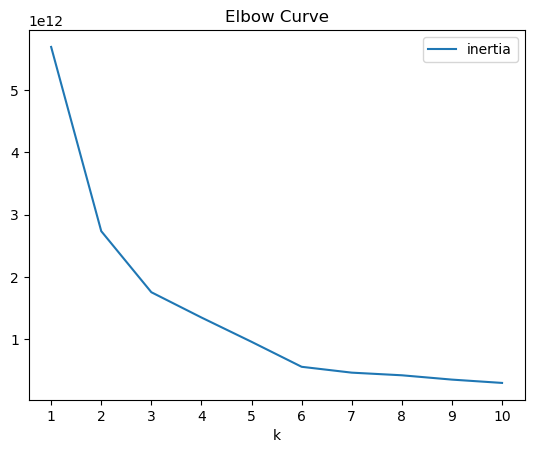

In [39]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

In [40]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 51.93%
Percentage decrease from k=2 to k=3: 35.82%
Percentage decrease from k=3 to k=4: 23.11%
Percentage decrease from k=4 to k=5: 28.87%
Percentage decrease from k=5 to k=6: 41.75%
Percentage decrease from k=6 to k=7: 16.78%
Percentage decrease from k=7 to k=8: 9.09%
Percentage decrease from k=8 to k=9: 16.39%
Percentage decrease from k=9 to k=10: 15.02%


### Elbow curve suggest that the optimal number for k is 5
The rate of decrease in inertia **begins** to slow down between k=4 to k=5, which means that our elbow point is at k=5.

### Implementing KMeans Model

In [119]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, n_init='auto', random_state=1)

# Fit the model
model.fit(means_df)

# Make predictions
k_3 = model.predict(means_df)

# Create a copy of the DataFrame
customers_predictions_df = means_df.copy()

# Add a class column with the labels
customers_predictions_df['flight_segment'] = k_3
customers_predictions_df.head()

,Flight,DayOfWeek,Time,Length,Delay,AirportFroIDs,AirportToIDs,airline_id,flight_segment
0,269,3,15,205,1,1,103,2824,2
1,1558,3,15,222,1,2,109,1409,0
2,2400,3,20,165,1,3,72,5506,2
3,2466,3,20,195,1,1,72,5506,2
4,108,3,30,202,0,4,22,5012,2


<Axes: title={'center': 'Scatter Plot by Shopping Segment - k=5'}, xlabel='Time', ylabel='Length'>

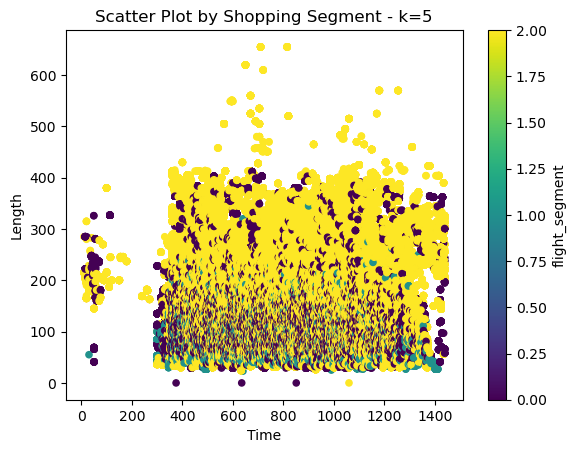

In [124]:
# Create a scatter plot with x="Frozen" and y="Grocery" with k=4 segments
customers_predictions_df.plot.scatter(
    x="Time", 
    y="Length", 
    c="flight_segment",
    title = "Scatter Plot by Shopping Segment - k=5",
    colormap='viridis'
)

In [131]:
us_flight_data = pd.read_csv('./data/UsRoutesAndFares.csv')
us_flight_data.columns

/var/folders/j8/8fz1pphj3d18kslnjh7scn_00000gn/T/ipykernel_90720/593846415.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  us_flight_data = pd.read_csv('./data/UsRoutesAndFares.csv')


Index(['tbl', 'Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1',
       'city2', 'airportid_1', 'airportid_2', 'airport_1', 'airport_2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'Geocoded_City1', 'Geocoded_City2',
       'tbl1apk'],
      dtype='object')